Emotion Recognition Using Voice

Dataset : https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
Technologies Used: Librosa, SoundDevice, SoundFile, numpy, pandas, Scikit-learn

Team Members:
21MIS1003 - Sanjay A
21MIS1021 - Vimal Kumar S
21MIS1036 - Poovithazhan K

In [16]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import joblib
import sounddevice as sd
import soundfile as sf

In [17]:
# Path to your dataset
dataset_path = 'C:/Users/SANJAY A/Emotion Recognition using Voice/RAVDESS'

In [18]:
# Create a list to store file paths and labels
file_paths = []
emotions = []

In [19]:
# Emotion labels
emotion_dict = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised',
    '09': 'excited'
}

In [20]:
# Loading data
for actor in os.listdir(dataset_path):
    actor_path = os.path.join(dataset_path, actor)
    if os.path.isdir(actor_path):
        for file_name in os.listdir(actor_path):
            file_path = os.path.join(actor_path, file_name)
            if file_name.endswith('.wav'):
                emotion_code = file_name.split('-')[2]
                emotion_label = emotion_dict[emotion_code]
                file_paths.append(file_path)
                emotions.append(emotion_label)

# Create DataFrame
data_df = pd.DataFrame({'file_path': file_paths, 'emotion': emotions})

In [21]:
# Feature extraction function
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    mfccs_scaled = np.mean(mfccs.T, axis=0)

    chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
    chroma_scaled = np.mean(chroma.T, axis=0)

    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate)
    spectral_contrast_scaled = np.mean(spectral_contrast.T, axis=0)

    zero_crossings = librosa.feature.zero_crossing_rate(y=audio)
    zero_crossings_scaled = np.mean(zero_crossings.T, axis=0)

    feature_vector = np.hstack([mfccs_scaled, chroma_scaled, spectral_contrast_scaled, zero_crossings_scaled])
    
    return feature_vector

In [22]:
# Extract features for all files
data_df['features'] = data_df['file_path'].apply(extract_features)

In [23]:
# Prepare data
X = np.array(data_df['features'].tolist())
y = np.array(data_df['emotion'].tolist())

In [24]:
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [25]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Initialize and train the model (Random Forest as an alternative)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [27]:
# Make predictions
y_pred = model.predict(X_test)

In [28]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 56.55%


In [29]:
# Save the trained model and scaler
joblib.dump(model, 'emotion_recognition_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [30]:
import matplotlib.pyplot as plt

In [31]:
# Real-time prediction function
def record_and_predict(duration=3, sample_rate=22050):
    print("Recording...")
    audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1)
    sd.wait()
    print("Recording finished.")
    
    audio = audio.flatten()
    sf.write('temp_audio.wav', audio, sample_rate)
    visualize_audio(audio, sample_rate)
    features = extract_features('temp_audio.wav')
    features = scaler.transform(features.reshape(1, -1))  # Normalize features
    predicted_emotion = model.predict(features)
    prediction_probabilities = model.predict_proba(features)
    confidence = np.max(prediction_probabilities) * 100  # Confidence level for the predicted emotion
    
    print(f'Predicted emotion: {predicted_emotion[0]} with confidence: {confidence:.2f}%')

In [32]:
# Function to visualize audio waveform
def visualize_audio(audio, sample_rate):
    plt.figure(figsize=(10, 4))
    plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
    plt.title("Recorded Audio Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()

Recording...
Recording finished.


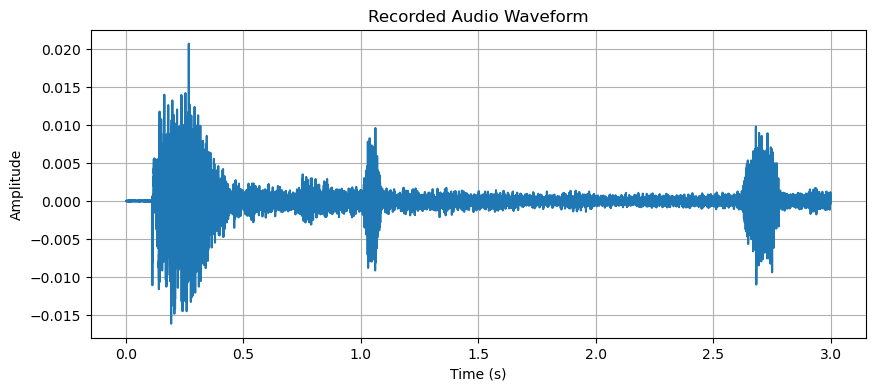

Predicted emotion: surprised with confidence: 22.00%


In [34]:
# Test the function
record_and_predict(duration=3)